# EIGSEP Horizons

Aaron Parsons

This notebook uses digital elevation models of Marjum canyon and proposed antenna locations to calculate the distance to surrounding terrain (saved in horizon_models_v000.npz), with NaNs above the horizon. These are used in other notebooks for taking into account horizon effects and for modeling terrain scattering.

In [1]:
import numpy as np
import matplotlib.pylab as plt
from eigsep_terrain.marjum_dem import MarjumDEM as DEM
import eigsep_terrain as et
import eigsep_terrain.utils as etu
import tqdm
import healpy

%matplotlib widget

In [2]:
CACHE_FILE = 'marjum_dem.npz'
dem = DEM(cache_file=CACHE_FILE)

In [3]:
def color_str2tup(s):
    r, g, b = s[0:2], s[2:4], s[4:6]
    return tuple(map(lambda x: int(x, base=16) / 255, (r, g, b)))

def plot_img(ax, data, res=dem.res, xlabel=True, ylabel=True,
             colorbar=False, cmap='terrain', erng=None, nrng=None, **kw):
    '''Plot maps with standard format.'''
    if nrng is None:
        nrng = (0, data.shape[0] * res)
    if erng is None:
        erng = (0, data.shape[1] * res)
    extent = erng + nrng
    im = ax.imshow(data, extent=extent, cmap=cmap, origin='lower', interpolation='nearest', **kw)
    if colorbar:
        plt.colorbar(im)
    if xlabel:
        ax.set_xlabel('East [m]')
    if ylabel:
        ax.set_ylabel('North [m]')

In [4]:
# Known sites
dem['1P'] = np.array([1648, 2024, 1796])  # Site 1, index 0, 114 m off ground
dem['1E'] = dem.interp_alt(1790, 1915, return_vec=True)  # Site 1, East anchor
dem['1W'] = dem.interp_alt(1518, 2124, return_vec=True)  # Site 1, West anchor

#dem['2P'] = np.array([1740, 2264, 1833])  # Site 2, index 2, 124 m off ground
#dem['2E'] = dem.interp_alt(1920, 2240, return_vec=True)  # Site 2, East anchor
#dem['2W'] = dem.interp_alt(1538, 2291, return_vec=True)  # Site 2, West anchor

1642.8159009458857 2046.4781472435452 1685


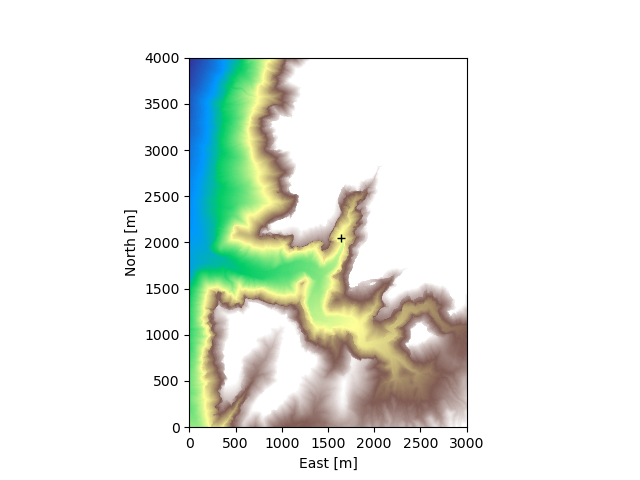

In [5]:
e,n,u = dem.latlon_to_enu(39.247907, -113.402715)
u = dem.interp_alt(e, n)
print(e, n, u)
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res, vmin=u-200, vmax=u+200)
plt.plot([e], [n], '+', color='k')

In [6]:
# Calculate the horizon angle of the terrain surrounding the antenna
horizon_angles = {}
horizon_pnts = {}
#for k in ('1', '2'):
for k in ('1'):
    pnt = dem[k + 'P']
    for delta_h in (0,):
        _pnt = pnt + np.array([0, 0, delta_h])
        horizon_angles[k+' '+str(delta_h)], horizon_pnts[k+' '+str(delta_h)] = dem.calc_horizon(*_pnt, n_az=512)

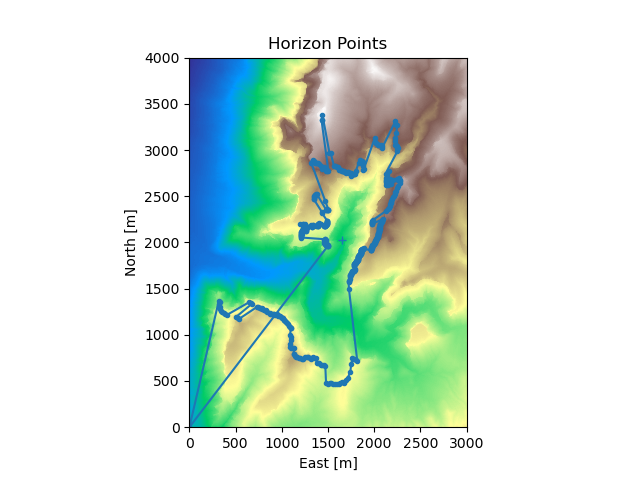

In [7]:
fig, ax = plt.subplots()
plot_img(ax, dem.data, dem.res)
for k in horizon_angles.keys():
    color = ax._get_lines.get_next_color()
    plt.plot(horizon_pnts[k][1], horizon_pnts[k][0], '.-', color=color)
    plt.plot([dem[k[0] + 'P'][0]], [dem[k[0] + 'P'][1]], '+', color=color)
_ = plt.title('Horizon Points')

/tmp/ipykernel_217399/3867654617.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


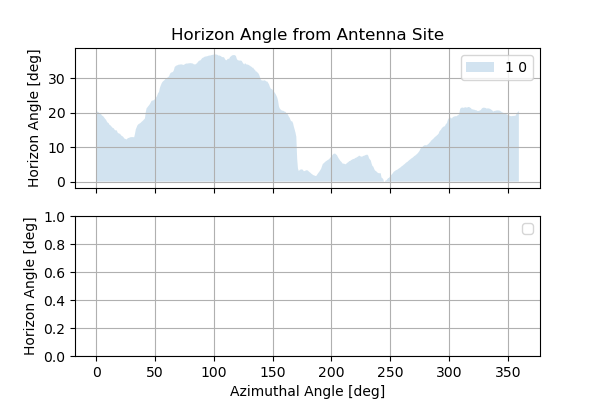

In [8]:
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(6,4))
axes[0].set_title('Horizon Angle from Antenna Site')
for k in horizon_angles.keys():
    if k.startswith('1'):
        ax = axes[0]
    else:
        ax = axes[1]
    ax.fill_between(np.linspace(0, 360, horizon_angles[k].size, endpoint=False), np.rad2deg(horizon_angles[k]), 0, alpha=0.2, label=k)
axes[1].set_xlabel('Azimuthal Angle [deg]')
for ax in axes:
    ax.legend()
    ax.set_ylabel('Horizon Angle [deg]')
    _ = ax.grid()

In [27]:
e0, n0, u0 = dem['1P']
u_gnd = dem.interp_alt(e0, n0)
nside_full = 64
#heights = np.linspace(1, u0 - u_gnd, 10)
heights = np.array([u0 - u_gnd])
r = np.empty((heights.size, healpy.nside2npix(nside_full)), dtype=np.float32)
centers = np.empty((heights.size, 3), dtype=np.float32)
for i, dh in enumerate(heights):
    centers[i] = (e0, n0, u_gnd+dh)
    r[i] = dem.ray_trace_distances(centers[i], nside=nside_full)

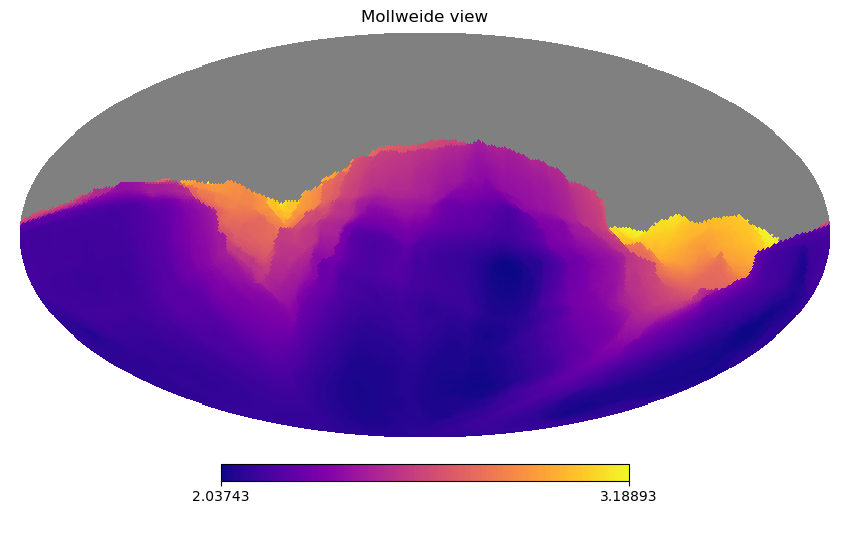

In [36]:
#healpy.mollview(h.map)
healpy.mollview(np.log10(r[-1]), cmap='plasma')
#healpy.mollview(T[-1], cmap='plasma')
#healpy.mollview((T_sky_full[:, 180]), cmap='plasma')

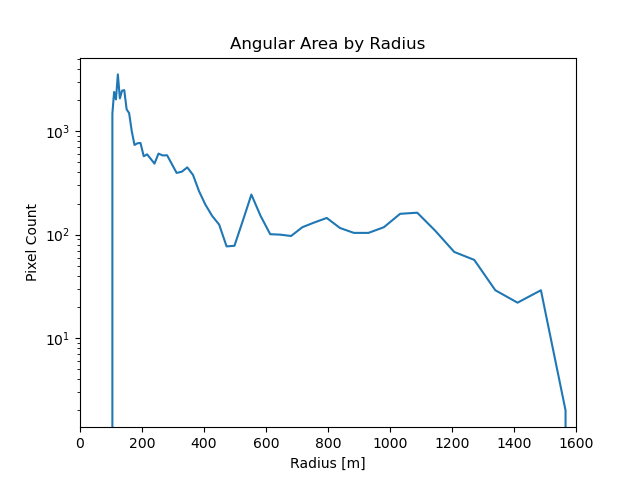

In [18]:
fig, axes = plt.subplots()
for i, dh in enumerate(heights):
    h, bins = np.histogram(r[i], bins=np.logspace(-1, 3.5, 200))
    axes.semilogy(0.5 * (bins[1:] + bins[:-1]), h, label=dh)
axes.set_title('Angular Area by Radius')
axes.set_xlim(0, 1600)
axes.set_ylabel('Pixel Count')
_ = axes.set_xlabel('Radius [m]')